# Contents

__[1. Introduction](#Introduction)__  

__[2. Loading modules and data](#Loading-modules-and-data)__  

__[3. Preprocessing](#Preprocessing)__  

__[4. Exploratory analysis and feature engineering](#Exploratory-analysis-and-feature-engineering)__  
    [4.1. Profiling variables](#Profiling-variables)  
    [4.1. Data transformation and Clustering variables](#Data-transformation-and-Clustering-variables)

__[5. Model Selection](#Model-Selection)__  

__[6. Analysis](#Analysis)__  



# Introduction

Clustering is an unsupervised machine learning task, involving discovering groups in data. Clustering helps with pattern discovery. This project aims to use clustering approaches to perform customer segmentation on [Online Retail data](https://www.kaggle.com/datasets/vijayuv/onlineretail).


### Use cases:
- __data summarization__
    - clustering is a step for classification or outlier analysis
    - dimensionality reduction
- __collaborative filtering__
    - grouping of users with similar interests
- __customer segmentation__
    - grouping of customers
- __dynamic trend detection__
    - in social networks:  data is dynamically clustered in a streaming fashion and used to determine patterns of changes.
- __multimedia data analysis__
    - detecting similar areas in images, video, audio.
- __social network analysis__
    - detecting communities
    
### Validation  
- use __case studies__ to illustrate the subjective quality of the clusters
- __measures of the clusters__ (cluster radius or density)
    - can be biased (measures could favor different algorithms in a different way)
- labels can be given to data points - then __correlations of the clusters with the labels__ can be used
    - class labels may not always align with the natural clusters
    
    
### Approach

1. Define goals: find users that are similar in important ways to the business (producs, usage, demographics, channels, etc) and:
    - discover how business metrics differ between them.
    - use that information to improve existing models.
    - tailor marketing strategy to each customer segment.
    
    
2. Data:
    1. Behavioural data (transactions):
        - visits, usage, penetration responses, engagement, lifestyle, preferences, channel preferences, etc.
        - number of times a user purchased, how much, what products and categories.
        - number of transactions over a period of time, number of units.
    1. Additional data:
        1. User side:
            - time between purchases, categories purchased, peaks and valleys of transactions, units and revenue, share of categories, number of units and transactions per user, percentage of discounts per user, top N categories purchased per user.
        1. Company side:
            - seasonality variables, featured categories, promotions in place.
        1. Third party data:
            - demographics, interests, attitudes, lifestyles.
    

3. Implement a model:
    - model should be multivariate, multivariable, probabilistic (e.g. LCA).
    - run model (e.g. linear regression) for each segment separately, thus taking into account different user profiles.


4. Analyse returned segments:
    - some segments could be price sensitive, prefer one channel, have high penetration of a particular product, prefer a certain way of communication.
    - we expect to find a segment that is penetrated in one category, but not another.
    - profiling:
        - profile - what is shown to managers as a proof that the segments are different: 
            - KPIs.
            - indexes (e.g. take each segment's mean and divide by total mean to show how a segment is different from the rest in percentage).
    - name the segments (e.g. high revenue, low response, etc.)
    
    
5. Act based on learnt information:
    - e.g. if a segment is price sensitive, users should get a discount to motivate them to make a purchase.


__[🔼](#Contents)__  


# Loading modules and data

In [241]:
import pandas as pd
import numpy as np
from importlib import reload
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.cluster import SpectralClustering, OPTICS, MeanShift, KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

import tools as t
reload(t)

from tools.preprocessing import eda
from tools.preprocessing import feature_selection as fe
from tools.modeling import clustering


In [47]:
data = eda.Dataset(
    features=['StockCode', 'InvoiceDate', 'Country', 'Quantity', 'UnitPrice', 'CustomerID'],
    features_ohe=['StockCode', 'Country'],
)
print(data)

Data transformation class.         
---------------------------        
Inputted features: ['StockCode', 'InvoiceDate', 'Country', 'Quantity', 'UnitPrice', 'CustomerID'].         
---------------------------        
Transformation steps:         
1. Correct data types         
2. Feature engineering: Revenue         
3. One Hot Encoding of ['StockCode', 'Country']        


__[🔼](#Contents)__  

# Preprocessing

In [48]:
df0 = data.get_transformed()

__[🔼](#Contents)__  

# Exploratory analysis and feature engineering

## Profiling variables



In [59]:
df_profiling = data.get_profiling_df()
df_profiling.dropna(inplace=True)
df_profiling

,#_stockCode,#_InvoiceNo,avg_Q,avg_P,avg_Revenue,HighRevenueMonth
CustomerID,,,,,,
17850,312.0,35.0,5.426282,3.924712,16.950737,2.0
13047,196.0,18.0,6.913265,4.072959,15.709694,3.0
12583,251.0,18.0,19.956175,3.152510,28.634821,7.0
13748,28.0,5.0,15.678571,3.996429,33.866071,5.0
15100,6.0,6.0,9.666667,10.950000,105.850000,8.0
...,...,...,...,...,...,...
13436,12.0,1.0,6.333333,5.830000,16.407500,8.0
15520,18.0,1.0,17.444444,1.724444,19.083333,8.0
13298,2.0,1.0,48.000000,3.750000,180.000000,8.0


__[🔼](#Contents)__  

## Data transformation and Clustering variables

These are variables that will be used in clustering algorithm.

The following transformations will be applied to them:
- Observations with missing values will be dropped.
- One Hot Encoding will be used to encode categorical variables (`'StockCode', 'Country'`).
- We will also break down `InvoiceDate` into Year, Month, Day.
- `Description` will be dropped since strings can't be used in clustering algorithms.



In [60]:
df_clustering = data.get_clustering_df()
df_clustering

,Quantity,UnitPrice,InvoiceYear,InvoiceMonth,InvoiceDay,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123C,StockCode_10123G,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850,6,2.55,2010,1,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17850,6,3.39,2010,1,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17850,8,2.75,2010,1,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17850,6,3.39,2010,1,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17850,6,3.39,2010,1,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12680,12,0.85,2011,9,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12680,6,2.10,2011,9,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12680,4,4.15,2011,9,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_clustering.dropna(inplace=True)

In [62]:
df_clustering = df_clustering.iloc[:1000, :]
# df_clustering

__[🔼](#Contents)__  

## Feature selection


In [237]:
# X = df_clustering.reset_index(drop=True)
# y = pd.Series(df_clustering.index)
X = df_clustering.reset_index(drop=True)
y = df_clustering.reset_index()['CustomerID']

In [234]:
# X = df_profiling.reset_index(drop=True)
# y = pd.Series(df_profiling.index)
X = df_profiling.reset_index(drop=True)
y = df_profiling.reset_index()['CustomerID']

In [212]:
df_clustering_lw = fe.low_variance(df_clustering, threshold=0.25) 

Dimensionality reduced from 4113 to 594.


C:\Users\nastiag67\Anaconda3\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [228]:
# # NOT WORKING probably cuz too sparse: AttributeError: 'bool' object has no attribute 'any'
# df_clustering_fe, mask_fe = fe.RFE_selection(X=X, y=y, n_features_to_select=1000, step=1, mask=None)

In [238]:
# # NOT WORKING probably cuz too sparse: AttributeError: 'bool' object has no attribute 'any'
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# MODEL1
gbc = GradientBoostingClassifier()
# MODEL2
lda = LinearDiscriminantAnalysis(n_components=2)
models={'GBC': gbc, 'LDA': lda}

df_clustering_ens, mask_ens = f.ensemble(X=X, y=y, models=models, n_features_to_select=1000, mask=None)

RFE using the model: GBC


AttributeError: 'bool' object has no attribute 'any'

In [239]:
df_clustering_tree, mask_tree = f.tree_based(X=X, y=y, threshold=0.0016, mask=None)

AttributeError: 'bool' object has no attribute 'any'

In [240]:
df_clustering_extratree, mask_extratree = f.extra_trees(X=X, y=y, st_scaler=True, mask=None)

AttributeError: 'bool' object has no attribute 'any'

__[🔼](#Contents)__  

# Model Selection

In [77]:
import tools as t
reload(t)
from tools.modeling import clustering

clustering = clustering.Clustering(df_clustering)

KMeans(n_clusters=3, random_state=42)


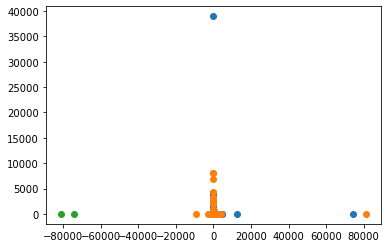

In [80]:
name = 'Kmeans'
model = KMeans(n_clusters=3, random_state=42)
steps = [
    ('PCA', PCA(n_components=2)),
    ('scaler', StandardScaler()),
]
plot=True

model_kmeans, ypred_kmeans = clustering.check_model(name, model, steps, plot)

In [81]:
df_clustering['clusters'] = ypred_kmeans
df_clustering_res = df_clustering[['CustomerID', 'clusters']].copy()
df_clustering_res

In [86]:
df_clustering_res

,CustomerID,clusters
0,17850,1
1,17850,1
2,17850,1
3,17850,1
4,17850,1
...,...,...
541904,12680,0
541905,12680,0
541906,12680,0
541907,12680,0


__[🔼](#Contents)__  

# Analysis

In [84]:
df_res = pd.merge(df_clustering_res, df_profiling.drop_duplicates(), how='left', left_on='CustomerID', right_index=True)
df_res

,CustomerID,clusters,#_stockCode,#_InvoiceNo,avg_Q,avg_P,avg_Revenue,HighRevenueMonth
0,17850,1,312.0,35.0,5.426282,3.924712,16.950737,2.0
1,17850,1,312.0,35.0,5.426282,3.924712,16.950737,2.0
2,17850,1,312.0,35.0,5.426282,3.924712,16.950737,2.0
3,17850,1,312.0,35.0,5.426282,3.924712,16.950737,2.0
4,17850,1,312.0,35.0,5.426282,3.924712,16.950737,2.0
...,...,...,...,...,...,...,...,...
541904,12680,0,52.0,4.0,8.519231,3.637885,16.592500,9.0
541905,12680,0,52.0,4.0,8.519231,3.637885,16.592500,9.0
541906,12680,0,52.0,4.0,8.519231,3.637885,16.592500,9.0
541907,12680,0,52.0,4.0,8.519231,3.637885,16.592500,9.0


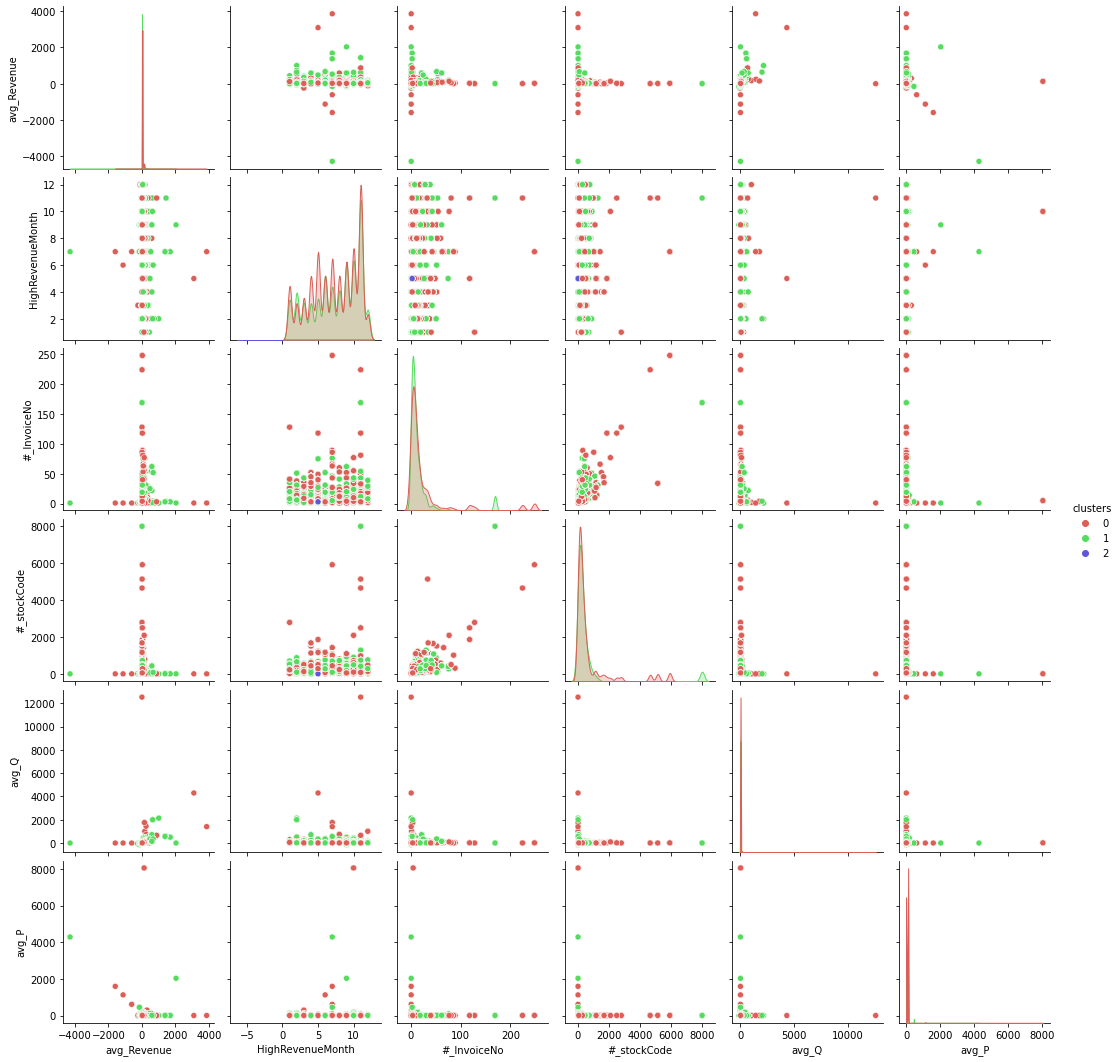

In [87]:
sns.pairplot(df_res[['clusters', 'avg_Revenue', 'HighRevenueMonth', '#_InvoiceNo', '#_stockCode', 'avg_Q', 'avg_P']], 
             hue="clusters",
            palette=sns.color_palette("hls", 3))


# TEST

In [68]:
import os
import matplotlib.pyplot as plt
import math
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

directory = '../data/delete/'

mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory+filename)
        df = df.loc[:,["date","value"]]
        # While we are at it I just filtered the columns that we will be working on
        df.set_index("date",inplace=True)
        # ,set the date columns as index
        df.sort_index(inplace=True)
        # and lastly, ordered the data according to our date index
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])


In [69]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{332, 333}


In [70]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [71]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

In [72]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)
nan_counter(mySeries)

3


In [73]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [74]:
nan_counter(mySeries)

0


In [75]:
from sklearn.preprocessing import MinMaxScaler
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [76]:
pd.DataFrame(mySeries)

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
0,0.539535,0.539535,0.596279,0.546977,0.541395,0.476279,0.502326,0.586977,0.437209,0.580465,...,0.694884,0.150698,0.495814,0.660465,0.471628,0.575814,0.457674,0.513488,0.567442,0.389767
1,0.000381,0.001327,0.000000,0.003894,0.006998,0.009505,0.012555,0.013526,0.018354,0.021315,...,0.924180,0.947177,0.937122,0.964642,0.969339,0.975378,0.979856,0.990736,1.000000,0.992850
2,0.000000,0.014898,0.059923,0.059379,0.073626,0.098838,0.088902,0.060437,0.074004,0.081264,...,0.881137,0.666717,0.675535,0.909722,0.822877,0.931849,0.845549,0.912429,1.000000,0.814997
3,0.016194,0.040937,0.059747,0.102394,0.059143,0.062764,0.067190,0.050694,0.043553,0.056930,...,0.668377,0.710521,0.790787,1.000000,0.847516,0.869040,0.823476,0.838161,0.846409,0.751760
4,0.000000,0.010153,0.027766,0.021550,0.041235,0.043514,0.032947,0.031082,0.043514,0.054911,...,0.929134,0.918152,0.939909,0.975135,0.974720,0.972441,0.969333,0.967882,1.000000,0.971405
5,0.000000,0.008321,0.041739,0.039592,0.057576,0.068581,0.075292,0.080526,0.064689,0.087371,...,0.951684,0.635485,0.608777,0.798148,0.728090,0.826466,0.753590,0.809690,0.862971,0.791974
6,0.000000,0.015447,0.013340,0.018431,0.013516,0.025803,0.020011,0.020713,0.015973,0.007899,...,0.932947,0.926804,0.936633,0.960330,0.973495,0.971564,0.965420,0.971915,0.974372,0.986660
7,0.004669,0.007244,0.010822,0.000000,0.001702,0.002269,0.002051,0.007724,0.010560,0.010168,...,0.908274,1.000000,0.905874,0.918310,0.905088,0.880607,0.890819,0.902775,0.934151,0.909190
8,0.001618,0.008089,0.019414,0.035187,0.064914,0.055410,0.083114,0.073003,0.054398,0.077048,...,1.000000,0.532659,0.529019,0.641658,0.623054,0.729221,0.708797,0.756320,0.761780,0.641658
9,0.014623,0.010812,0.017815,0.025693,0.021470,0.013799,0.008341,0.010607,0.000000,0.018793,...,0.988518,0.959222,0.867830,0.935383,0.960148,1.000000,0.893780,0.941201,0.951910,0.899547


In [46]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.53953488 0.53953488 0.59627907 0.54697674 0.54139535]


In [17]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)


In [62]:
labels

array([2, 1, 3, 3, 1, 3, 3, 3, 4, 1, 4, 1, 1, 4, 4, 1, 1, 1, 0, 2, 0, 3,
       1], dtype=int64)

In [18]:
pd.DataFrame(mySeries)

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
0,0.539535,0.539535,0.596279,0.546977,0.541395,0.476279,0.502326,0.586977,0.437209,0.580465,...,0.694884,0.150698,0.495814,0.660465,0.471628,0.575814,0.457674,0.513488,0.567442,0.389767
1,0.000381,0.001327,0.000000,0.003894,0.006998,0.009505,0.012555,0.013526,0.018354,0.021315,...,0.924180,0.947177,0.937122,0.964642,0.969339,0.975378,0.979856,0.990736,1.000000,0.992850
2,0.000000,0.014898,0.059923,0.059379,0.073626,0.098838,0.088902,0.060437,0.074004,0.081264,...,0.881137,0.666717,0.675535,0.909722,0.822877,0.931849,0.845549,0.912429,1.000000,0.814997
3,0.016194,0.040937,0.059747,0.102394,0.059143,0.062764,0.067190,0.050694,0.043553,0.056930,...,0.668377,0.710521,0.790787,1.000000,0.847516,0.869040,0.823476,0.838161,0.846409,0.751760
4,0.000000,0.010153,0.027766,0.021550,0.041235,0.043514,0.032947,0.031082,0.043514,0.054911,...,0.929134,0.918152,0.939909,0.975135,0.974720,0.972441,0.969333,0.967882,1.000000,0.971405
5,0.000000,0.008321,0.041739,0.039592,0.057576,0.068581,0.075292,0.080526,0.064689,0.087371,...,0.951684,0.635485,0.608777,0.798148,0.728090,0.826466,0.753590,0.809690,0.862971,0.791974
6,0.000000,0.015447,0.013340,0.018431,0.013516,0.025803,0.020011,0.020713,0.015973,0.007899,...,0.932947,0.926804,0.936633,0.960330,0.973495,0.971564,0.965420,0.971915,0.974372,0.986660
7,0.004669,0.007244,0.010822,0.000000,0.001702,0.002269,0.002051,0.007724,0.010560,0.010168,...,0.908274,1.000000,0.905874,0.918310,0.905088,0.880607,0.890819,0.902775,0.934151,0.909190
8,0.001618,0.008089,0.019414,0.035187,0.064914,0.055410,0.083114,0.073003,0.054398,0.077048,...,1.000000,0.532659,0.529019,0.641658,0.623054,0.729221,0.708797,0.756320,0.761780,0.641658
9,0.014623,0.010812,0.017815,0.025693,0.021470,0.013799,0.008341,0.010607,0.000000,0.018793,...,0.988518,0.959222,0.867830,0.935383,0.960148,1.000000,0.893780,0.941201,0.951910,0.899547


In [22]:
len(mySeries)

23

In [56]:
pd.DataFrame(mySeries)

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
0,0.539535,0.539535,0.596279,0.546977,0.541395,0.476279,0.502326,0.586977,0.437209,0.580465,...,0.694884,0.150698,0.495814,0.660465,0.471628,0.575814,0.457674,0.513488,0.567442,0.389767
1,0.000381,0.001327,0.000000,0.003894,0.006998,0.009505,0.012555,0.013526,0.018354,0.021315,...,0.924180,0.947177,0.937122,0.964642,0.969339,0.975378,0.979856,0.990736,1.000000,0.992850
2,0.000000,0.014898,0.059923,0.059379,0.073626,0.098838,0.088902,0.060437,0.074004,0.081264,...,0.881137,0.666717,0.675535,0.909722,0.822877,0.931849,0.845549,0.912429,1.000000,0.814997
3,0.016194,0.040937,0.059747,0.102394,0.059143,0.062764,0.067190,0.050694,0.043553,0.056930,...,0.668377,0.710521,0.790787,1.000000,0.847516,0.869040,0.823476,0.838161,0.846409,0.751760
4,0.000000,0.010153,0.027766,0.021550,0.041235,0.043514,0.032947,0.031082,0.043514,0.054911,...,0.929134,0.918152,0.939909,0.975135,0.974720,0.972441,0.969333,0.967882,1.000000,0.971405
5,0.000000,0.008321,0.041739,0.039592,0.057576,0.068581,0.075292,0.080526,0.064689,0.087371,...,0.951684,0.635485,0.608777,0.798148,0.728090,0.826466,0.753590,0.809690,0.862971,0.791974
6,0.000000,0.015447,0.013340,0.018431,0.013516,0.025803,0.020011,0.020713,0.015973,0.007899,...,0.932947,0.926804,0.936633,0.960330,0.973495,0.971564,0.965420,0.971915,0.974372,0.986660
7,0.004669,0.007244,0.010822,0.000000,0.001702,0.002269,0.002051,0.007724,0.010560,0.010168,...,0.908274,1.000000,0.905874,0.918310,0.905088,0.880607,0.890819,0.902775,0.934151,0.909190
8,0.001618,0.008089,0.019414,0.035187,0.064914,0.055410,0.083114,0.073003,0.054398,0.077048,...,1.000000,0.532659,0.529019,0.641658,0.623054,0.729221,0.708797,0.756320,0.761780,0.641658
9,0.014623,0.010812,0.017815,0.025693,0.021470,0.013799,0.008341,0.010607,0.000000,0.018793,...,0.988518,0.959222,0.867830,0.935383,0.960148,1.000000,0.893780,0.941201,0.951910,0.899547


In [54]:
df_clustering

,Quantity,UnitPrice,CustomerID,InvoiceYear,InvoiceMonth,InvoiceDay,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123C,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,6,2.55,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6,3.39,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8,2.75,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6,3.39,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,3.39,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14197,12,1.65,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14198,6,2.95,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14199,6,2.95,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14200,6,1.95,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
df_clustering

,Quantity,UnitPrice,CustomerID,InvoiceYear,InvoiceMonth,InvoiceDay,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123C,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,6,2.55,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6,3.39,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8,2.75,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6,3.39,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,3.39,17850,2010,1,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14197,12,1.65,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14198,6,2.95,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14199,6,2.95,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14200,6,1.95,17735,2010,7,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
class Solution(object):
    def groupAnagrams0(self, strs):
        """
        :type strs: List[str]
        :rtype: List[List[str]]
        """
        ans=collections.defaultdict(list)
        for s in strs:
            ans[tuple(sorted(s))].append(s)
        return ans.values()

    def groupAnagrams(self, strs):
        ans = collections.defaultdict(list)
        for s in strs:
            count = [0] * 26
            for c in s:
                count[ord(c) - ord('a')] += 1
            ans[tuple(count)].append(s)
        return ans.values()

import sys, collections
strs = ["eat","tea","tan","ate","nat","bat"]
s = Solution()
print(s.groupAnagrams(strs))
print(s.groupAnagrams0(strs))

dict_values([['eat', 'tea', 'ate'], ['tan', 'nat'], ['bat']])
dict_values([['eat', 'tea', 'ate'], ['tan', 'nat'], ['bat']])


In [6]:
a={}
a[tuple('k')]=(5)
a

{('k',): 5}

In [8]:
a.values()

dict_values([5])

In [2]:
import collections
collections.defaultdict(list)

defaultdict(list, {})